# 1. Autoencoder

### Load libraries

In [67]:
import keras
from keras import layers
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and preprocess the data

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [124]:
file_path = "/content/gdrive/My Drive/cifar/"

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

def normalize(file):
  return np.reshape(file[b'data'], (len(file[b'data']), 32, 32, 3), order='F').transpose([0,2,1,3]).astype('float32') / 255., np.asarray(file[b'labels']).reshape((len(file[b'labels']), 1))

names = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]

for i in range(6):
  # load data
  file_name = file_path + names[i]
  output = unpickle(file_name)
  # normalize data
  x_batch, y_batch = normalize(output)
  # gather train and test
  if i == 0:
    x_train, y_train = x_batch, y_batch
  elif i != 5:
    x_train = np.concatenate((x_train, x_batch), axis=0)
    y_train = np.concatenate((y_train, y_batch), axis=0)
  else:
    x_test, y_test = x_batch, y_batch

In [125]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### Take a look at a few images

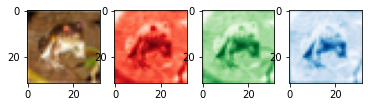

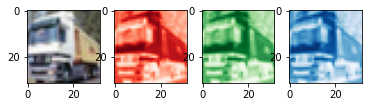

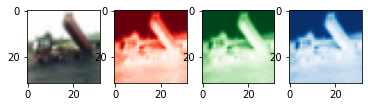

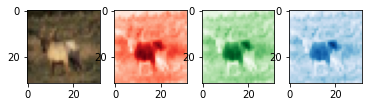

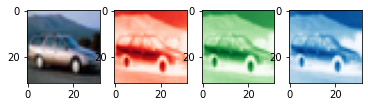

In [53]:
for i in range(5): 
  plt.subplot(1,4,1)
  plt.imshow(x_train[i,:])
  plt.subplot(1,4,2)
  plt.imshow(output[b'data'][i][:1024].reshape(32,32), cmap='Reds')
  plt.subplot(1,4,3)
  plt.imshow(output[b'data'][i][1024:2048].reshape(32,32), cmap='Greens')
  plt.subplot(1,4,4)
  plt.imshow(output[b'data'][i][2048:].reshape(32,32), cmap='Blues')
  plt.show()

### Build the model

In [102]:
input_img = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (13, 13), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 4, 4, 8)         

In [106]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
result = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
391/391 [==============================] - 310s 792ms/step - loss: 0.6139 - val_loss: 0.5994
Epoch 2/10
391/391 [==============================] - 308s 789ms/step - loss: 0.5962 - val_loss: 0.5960
Epoch 3/10
391/391 [==============================] - 309s 790ms/step - loss: 0.5931 - val_loss: 0.5926
Epoch 4/10
391/391 [==============================] - 322s 822ms/step - loss: 0.5915 - val_loss: 0.5912
Epoch 5/10
391/391 [==============================] - 317s 810ms/step - loss: 0.5901 - val_loss: 0.5910
Epoch 6/10
391/391 [==============================] - 328s 839ms/step - loss: 0.5892 - val_loss: 0.5893
Epoch 7/10
391/391 [==============================] - 324s 829ms/step - loss: 0.5884 - val_loss: 0.5900
Epoch 8/10
391/391 [==============================] - 331s 846ms/step - loss: 0.5877 - val_loss: 0.5899
Epoch 9/10
391/391 [==============================] - 318s 814ms/step - loss: 0.5871 - val_loss: 0.5873
Epoch 10/10
391/391 [==============================] - 315s 806m

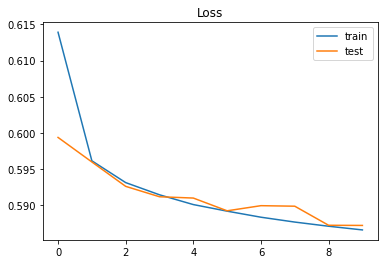

In [110]:
plt.title('Loss')
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

# 2. Image classification 

## 2.1 Deep CNN

In [136]:
input_img = keras.Input(shape=(32, 32, 3))

# first CNN layer
x = layers.Conv2D(filters = 32, kernel_size=2, strides=2, 
                      padding="valid", activation='relu', input_shape=(32, 32, 3))(input_img)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# second CNN layer
x = layers.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
# third CNN layer
x = layers.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')(x)
x = layers.MaxPool2D(pool_size=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
# dense
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(10, activation='sigmoid')(x)
cnn = keras.Model(input_img, x)
cnn.summary()

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 16, 16, 32)        416       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 7, 7, 16)          2064      
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 3, 16)        

In [139]:
from keras.utils.np_utils import to_categorical   

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [147]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy')
results = cnn.fit(x_train, y_train_cat,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test_cat),
                callbacks=[TensorBoard(log_dir='/tmp/cnn')])

Epoch 1/20
391/391 [==============================] - 12s 31ms/step - loss: 1.8252 - val_loss: 1.7320
Epoch 2/20
391/391 [==============================] - 12s 31ms/step - loss: 1.8140 - val_loss: 1.7079
Epoch 3/20
391/391 [==============================] - 12s 31ms/step - loss: 1.8031 - val_loss: 1.7039
Epoch 4/20
391/391 [==============================] - 12s 31ms/step - loss: 1.7956 - val_loss: 1.7108
Epoch 5/20
391/391 [==============================] - 12s 31ms/step - loss: 1.7881 - val_loss: 1.6711
Epoch 6/20
391/391 [==============================] - 13s 34ms/step - loss: 1.7845 - val_loss: 1.6730
Epoch 7/20
391/391 [==============================] - 13s 34ms/step - loss: 1.7780 - val_loss: 1.6764
Epoch 8/20
391/391 [==============================] - 13s 32ms/step - loss: 1.7693 - val_loss: 1.6716
Epoch 9/20
391/391 [==============================] - 13s 33ms/step - loss: 1.7700 - val_loss: 1.6507
Epoch 10/20
391/391 [==============================] - 13s 33ms/step - loss: 1.764

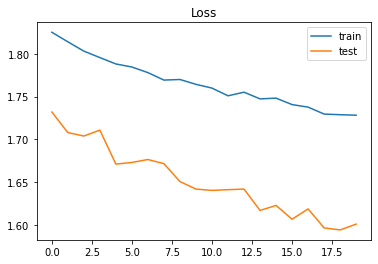

In [148]:
plt.title('Loss')
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2.2 Transfer Learning

In [142]:
from tensorflow.keras.applications import VGG16
import tensorflow.keras as tfk
tfkl = tfk.layers

In [143]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))

58892288/58889256 [==============================] - 3s 0us/step


In [144]:
transfer = tfk.Sequential()
transfer.add(conv_base)
transfer.add(tfkl.Flatten())
transfer.add(tfkl.Dense(10, activation = 'softmax'))
transfer.layers[0].trainable = False
transfer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [145]:
transfer.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

transfer_result = transfer.fit(x_train, y_train_cat, 
                    steps_per_epoch=20, 
                    epochs=10, 
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, y_test_cat),
                    callbacks=[TensorBoard(log_dir='/tmp/vgg')])

Epoch 1/10
20/20 [==============================] - 133s 7s/step - loss: 2.2382 - val_loss: 2.1135
Epoch 2/10
20/20 [==============================] - 129s 6s/step - loss: 2.0359 - val_loss: 1.9841
Epoch 3/10
20/20 [==============================] - 128s 6s/step - loss: 1.9237 - val_loss: 1.8855
Epoch 4/10
20/20 [==============================] - 131s 7s/step - loss: 1.8509 - val_loss: 1.8142
Epoch 5/10
20/20 [==============================] - 141s 7s/step - loss: 1.7815 - val_loss: 1.7573
Epoch 6/10
20/20 [==============================] - 135s 7s/step - loss: 1.7416 - val_loss: 1.7112
Epoch 7/10
20/20 [==============================] - 134s 7s/step - loss: 1.6754 - val_loss: 1.6745
Epoch 8/10
20/20 [==============================] - 132s 7s/step - loss: 1.6717 - val_loss: 1.6455
Epoch 9/10
20/20 [==============================] - 130s 7s/step - loss: 1.6229 - val_loss: 1.6206
Epoch 10/10
20/20 [==============================] - 129s 6s/step - loss: 1.6126 - val_loss: 1.5928


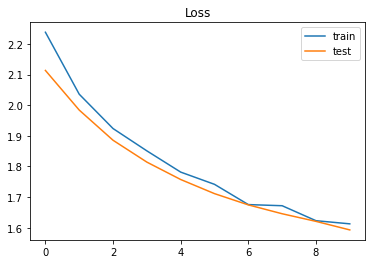

In [146]:
plt.title('Loss')
plt.plot(transfer_result.history['loss'], label='train')
plt.plot(transfer_result.history['val_loss'], label='test')
plt.legend()
plt.show()

# 3. Text Classification

## 3.1 RNN

In [149]:
text_file = "/content/gdrive/My Drive/SPAM_detection.csv"

import pandas as pd
spam = pd.read_csv(text_file)
spam.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [153]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = tfk.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(spam['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9006 unique tokens.


In [265]:
X = tokenizer.texts_to_sequences(spam['Message'].values)
X = tfk.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 250)


In [266]:
Y = pd.get_dummies(spam['category_val']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5572, 2)


In [267]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4457, 250) (4457, 2)
(1115, 250) (1115, 2)


In [268]:
MAX_N_WORDS = 50000
EMBEDDING_DIM = 500
model = tfk.Sequential()
model.add(tfkl.Embedding(MAX_N_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tfkl.Dropout(0.2))
model.add(tfkl.LSTM(100))
model.add(tfkl.Dropout(0.2))
model.add(tfkl.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 500)          25000000  
_________________________________________________________________
dropout_39 (Dropout)         (None, 250, 500)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 25,240,602
Trainable params: 25,240,602
Non-trainable params: 0
_________________________________________________________________


In [269]:
model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

results = model.fit(X_train, Y_train, 
                    steps_per_epoch=20, 
                    epochs=10, 
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test, Y_test),
                    callbacks=[TensorBoard(log_dir='/tmp/RNN')])

Epoch 1/10
20/20 [==============================] - 40s 2s/step - loss: 0.3467 - accuracy: 0.8656 - val_loss: 0.1570 - val_accuracy: 0.9570
Epoch 2/10
20/20 [==============================] - 38s 2s/step - loss: 0.0838 - accuracy: 0.9748 - val_loss: 0.0617 - val_accuracy: 0.9857
Epoch 3/10
20/20 [==============================] - 37s 2s/step - loss: 0.0300 - accuracy: 0.9910 - val_loss: 0.0473 - val_accuracy: 0.9901
Epoch 4/10
20/20 [==============================] - 37s 2s/step - loss: 0.0311 - accuracy: 0.9921 - val_loss: 0.0385 - val_accuracy: 0.9901
Epoch 5/10
20/20 [==============================] - 36s 2s/step - loss: 0.0086 - accuracy: 0.9988 - val_loss: 0.0389 - val_accuracy: 0.9901
Epoch 6/10
20/20 [==============================] - 38s 2s/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0411 - val_accuracy: 0.9892
Epoch 7/10
20/20 [==============================] - 37s 2s/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0462 - val_accuracy: 0.9910
Epoch 8/10
20/20 [==

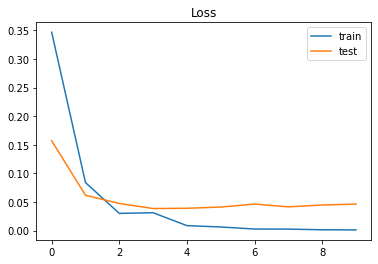

In [270]:
plt.title('Loss')
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3.2 1D-CNN

In [202]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import regex
import string
import unicodedata
import html
from html.parser import HTMLParser
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class Preprocessor(BaseEstimator, TransformerMixin):
    """
    This class is authored by Linda Moreau, professor for ANLY580 and is taken to use here directly.
    """

    def __init__(self, lower=True, strip=True, remove_punct=True, remove_diacritics=True, unicode_form='NFC', remove_stop=False, stem_tokens=False, lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [204]:
# Apply the preprocessor to my sentences to tokenize
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=False)
sent = spam['Message'].apply(my_preprocessor.tokenize).tolist()

In [207]:
# take a look at the top 2 sentences after tokenization
sent[:2]

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni']]

In [206]:
# create a word2vec model with my sentences
import gensim
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

In [224]:
# look at the embedding for a word in the vocabulary
model['go']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.5324301 , -0.0943414 , -0.00606942, -0.49569598, -0.1721442 ,
       -0.00926706,  0.16598094,  0.20090508,  0.5145977 ,  0.18448855,
        0.14569874, -0.11984104,  0.24478392, -0.541631  ,  0.39748883,
        0.169067  , -0.07561079, -0.21549463, -0.09669478,  0.80169445,
       -0.52156967,  0.06105425,  0.3109801 , -0.3153829 ,  0.10646982,
       -0.07259949,  0.10068466, -0.48047015, -0.30963737,  0.40516928,
       -0.48069707,  0.09217206, -0.16853936, -0.0955963 ,  0.3180922 ,
       -0.19655551,  0.08391072, -0.0978367 ,  0.55713016, -0.1640282 ,
       -0.01694881, -0.17530268, -0.35160154, -0.30801246,  0.29053393,
       -0.03302034, -0.09123983,  0.10038576,  0.10216092,  0.37457561],
      dtype=float32)

In [214]:
# Max length for my sentence
max_len = 0
max_len_sent = []
for item in sent:
  if len(item) > max_len:
    max_len = len(item)
    max_len_sent = item

In [215]:
max_len

76

In [232]:
# Reshape the data to (n_sample, n_timestamp (sequence order in the sentence), n_feature)
samp_time_feat = []
for item in sent:
  time_feat = []
  for word in item:
    em = model.wv[word]
    time_feat.append(em)
  if len(time_feat) < 76:
    diff = 76 - len(time_feat)
    time_feat = time_feat + [[0]*50]*diff
  time_feat = np.asarray(time_feat)
  samp_time_feat.append(time_feat)
samp_time_feat = np.asarray(samp_time_feat)
print(samp_time_feat.shape)

(5572, 76, 50)


In [239]:
# train test split
X_new = samp_time_feat
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4457, 76, 50) (4457, 2)
(1115, 76, 50) (1115, 2)


In [235]:
n_timestamps, n_features = X_new.shape[1], X_new.shape[2]

In [258]:
# Build the model
modelC2 = tfk.Sequential()
# First 1D-CNN layer
modelC2.add(tfkl.Conv1D(filters=32, kernel_size=3, strides = 8, padding='same', activation='relu', input_shape=(n_timestamps, n_features)))
modelC2.add(tfkl.MaxPooling1D(pool_size=2))
# Second 1D-CNN layer
modelC2.add(tfkl.Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(tfkl.MaxPooling1D(pool_size=2))
# Third 1D-CNN layer
modelC2.add(tfkl.Conv1D(filters=32, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(tfkl.MaxPooling1D(pool_size=2))
modelC2.add(tfkl.Dropout(0.2)) 
# 2 Dense layers 
modelC2.add(tfkl.Flatten())
modelC2.add(tfkl.Dense(50, activation='relu'))
modelC2.add(tfkl.Dropout(0.2))
modelC2.add(tfkl.Dense(2, activation='softmax'))
modelC2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 10, 32)            4832      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 5, 32)             0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 5, 16)             1552      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 2, 16)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 2, 32)             1568      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 32)           

In [251]:
# Train the model
modelC2.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

results2 = modelC2.fit(X_train, Y_train, 
                    steps_per_epoch=20, 
                    epochs=10, 
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test, Y_test),
                    callbacks=[TensorBoard(log_dir='/tmp/1dcnn')])

Epoch 1/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5741 - val_loss: 0.4188
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.3766 - val_loss: 0.3520
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.3444 - val_loss: 0.3306
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.3215 - val_loss: 0.3183
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.3246 - val_loss: 0.3089
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.2900 - val_loss: 0.2932
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.3048 - val_loss: 0.2707
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2645 - val_loss: 0.2515
Epoch 9/10
20/20 [==============================] - 0s 9ms/step - loss: 0.2553 - val_loss: 0.2222
Epoch 10/10
20/20 [==============================] - 0s 9ms/step - loss: 0.2143 - val_loss: 0.1820


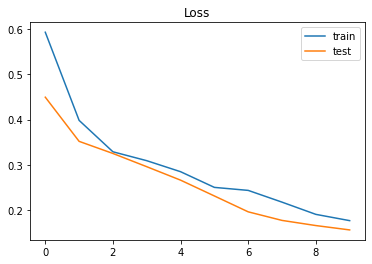

In [260]:
plt.title('Loss')
plt.plot(results2.history['loss'], label='train')
plt.plot(results2.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3.3 Model comparison

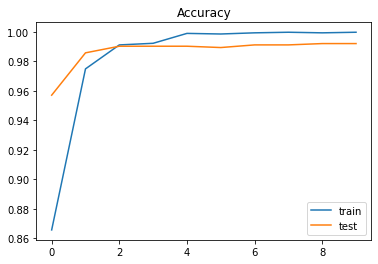

In [271]:
# RNN model
plt.title('Accuracy')
plt.plot(results.history['accuracy'], label='train')
plt.plot(results.history['val_accuracy'], label='test')
plt.legend()
plt.show();

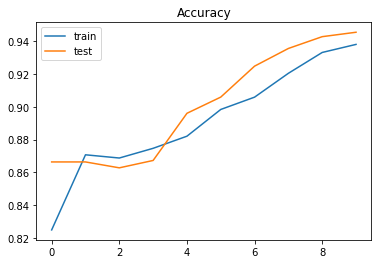

In [263]:
# 1DCNN model
plt.title('Accuracy')
plt.plot(results2.history['accuracy'], label='train')
plt.plot(results2.history['val_accuracy'], label='test')
plt.legend()
plt.show();


Both performances are quite good. RNN reached high accuracy a lot faster than 1D-CNN.